In [46]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [47]:
# Open ERA5 Single Levels; change name accordingly to yours. 
ds = xr.open_dataset('EU_MESOSCALE_SL.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 9)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T21:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    i10fg      (time, latitude, longitude) float32 ...
    kx         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-09 08:14:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [48]:
# Open ERA5 Pressure Levels; change name accordingly to yours.
ds1 = xr.open_dataset('EU_MESOSCALE_PL.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, level: 37, time: 5)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T18:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-07 06:42:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [42]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

# Select and grab data of ERA5 (CAPE, Surface and Isobaric winds)
cape = ds['cape'] # Proxy since SBCAPE ~= MUCAPE 
usurf = ds['u10']
vsurf = ds['v10']
uwind = ds1['u']
vwind = ds1['v']

# Let's calculate BRN Shear
# Calculate 0-6 km u and v component of mean winds with 50 hPa resolution 
# by indexing 'time' and 'pressure levels'

mean_uwind = np.mean([uwind[2, 20],uwind[2, 21],uwind[2, 22],uwind[2, 23],uwind[2, 24],
                      uwind[2, 25],uwind[2, 26],uwind[2, 28],uwind[2, 30],uwind[2, 32],
                      uwind[2, 34],uwind[2, 36],usurf[3,]], axis=0)

mean_uwind = gaussian_filter(mean_uwind, sigma=1) * units('m/s')

mean_vwind = np.mean([vwind[2, 20],vwind[2, 21],vwind[2, 22],vwind[2, 23],vwind[2, 24],
                      vwind[2, 25],vwind[2, 26],vwind[2, 28],vwind[2, 30],vwind[2, 32],
                      vwind[2, 34],vwind[2, 36],vsurf[3,]], axis=0)

mean_vwind = gaussian_filter(mean_vwind, sigma=1) * units('m/s')

# Calculate 0-500 m u and v component of mean winds 
# by indexing 'time' and 'pressure levels'

mean_usfc = np.mean([uwind[2, 34],uwind[2, 36],usurf[3,]], axis=0)

mean_usfc = gaussian_filter(mean_usfc, sigma=1) * units('m/s')

mean_vsfc = np.mean([vwind[2, 34],vwind[2, 36],vsurf[3,]], axis=0)

mean_vsfc = gaussian_filter(mean_usfc, sigma=1) * units('m/s')

# Compute for change in mean winds
del_uwind = mean_uwind - mean_usfc
del_vwind = mean_vwind - mean_vsfc

# Compute for shear magnitude 'M'
shear_mag = mpcalc.wind_speed(del_uwind, del_vwind)

brn_shear = 0.5 * (shear_mag * shear_mag)

In [43]:
# SCP requires SRH parameter. Therefore, we have to compute for the 0-6 km Mean Storm Motion.
# Compute for the 'user-defined' SRH starting with mean-winds and Storm-Relative Winds (SRW)

# Select u-component winds from surface to 700 hPa or ~3 km
uwnd_surf10 = gaussian_filter(usurf.data[3], sigma=1) * units('m/s')
uwnd_1000 = gaussian_filter(uwind.sel(level=1000).data[2], sigma=1) * units('m/s')
uwnd_975 = gaussian_filter(uwind.sel(level=950).data[2], sigma=1) * units('m/s')
uwnd_950 = gaussian_filter(uwind.sel(level=950).data[2], sigma=1) * units('m/s')
uwnd_925 = gaussian_filter(uwind.sel(level=925).data[2], sigma=1) * units('m/s')
uwnd_900 = gaussian_filter(uwind.sel(level=900).data[2], sigma=1) * units('m/s')
uwnd_875 = gaussian_filter(uwind.sel(level=875).data[2], sigma=1) * units('m/s')
uwnd_850 = gaussian_filter(uwind.sel(level=850).data[2], sigma=1) * units('m/s')
uwnd_825 = gaussian_filter(uwind.sel(level=825).data[2], sigma=1) * units('m/s')
uwnd_800 = gaussian_filter(uwind.sel(level=800).data[2], sigma=1) * units('m/s')
uwnd_775 = gaussian_filter(uwind.sel(level=775).data[2], sigma=1) * units('m/s')
uwnd_750 = gaussian_filter(uwind.sel(level=750).data[2], sigma=1) * units('m/s')
uwnd_700 = gaussian_filter(uwind.sel(level=700).data[2], sigma=1) * units('m/s')

# Select v-component winds from surface to 700 hPa or ~3 km
vwnd_surf10 = gaussian_filter(vsurf.data[3], sigma=1) * units('m/s')
vwnd_1000 = gaussian_filter(vwind.sel(level=1000).data[2], sigma=1) * units('m/s')
vwnd_975 = gaussian_filter(vwind.sel(level=950).data[2], sigma=1) * units('m/s')
vwnd_950 = gaussian_filter(vwind.sel(level=950).data[2], sigma=1) * units('m/s')
vwnd_925 = gaussian_filter(vwind.sel(level=925).data[2], sigma=1) * units('m/s')
vwnd_900 = gaussian_filter(vwind.sel(level=900).data[2], sigma=1) * units('m/s')
vwnd_875 = gaussian_filter(vwind.sel(level=875).data[2], sigma=1) * units('m/s')
vwnd_850 = gaussian_filter(vwind.sel(level=850).data[2], sigma=1) * units('m/s')
vwnd_825 = gaussian_filter(vwind.sel(level=825).data[2], sigma=1) * units('m/s')
vwnd_800 = gaussian_filter(vwind.sel(level=800).data[2], sigma=1) * units('m/s')
vwnd_775 = gaussian_filter(vwind.sel(level=775).data[2], sigma=1) * units('m/s')
vwnd_750 = gaussian_filter(vwind.sel(level=750).data[2], sigma=1) * units('m/s')
vwnd_700 = gaussian_filter(vwind.sel(level=700).data[2], sigma=1) * units('m/s')

# Calculate 0-6 km u and v component of 'standard' storm motion 
# by indexing 'time' and 'pressure levels'.

STM_u_mean = np.mean([uwind[2, 20],uwind[2, 21],uwind[2, 22],uwind[2, 23],uwind[2, 24],
                      uwind[2, 25],uwind[2, 26],uwind[2, 27],uwind[2, 28],uwind[2, 29],
                      uwind[2, 30],uwind[2, 31],uwind[2, 32],uwind[2, 33],uwind[2, 34],
                      uwind[2, 35],uwind[2, 36],usurf[3,]], axis=0)

STM_u_mean = gaussian_filter(STM_u_mean, sigma=1) * units('m/s')

STM_u_mean = STM_u_mean * (75 / 100)

STM_v_mean = np.mean([vwind[2, 20],vwind[2, 21],vwind[2, 22],vwind[2, 23],vwind[2, 24],
                      vwind[2, 25],vwind[2, 26],vwind[2, 27],vwind[2, 28],vwind[2, 29],
                      vwind[2, 30],vwind[2, 31],vwind[2, 32],vwind[2, 33],vwind[2, 34],
                      vwind[2, 35],vwind[2, 36],vsurf[3,]], axis=0)

STM_v_mean = gaussian_filter(STM_v_mean, sigma=1) * units('m/s')

STM_v_mean = STM_v_mean * (75 / 100)

# Calculate U-component Storm-Relative Winds

usrw_sfc = uwnd_surf10 - STM_u_mean # 10m SRW
usrw_1000 = uwnd_1000 - STM_u_mean #1000 hPa SRW
usrw_975 = uwnd_975 - STM_u_mean #975 hPa SRW
usrw_950 = uwnd_950 - STM_u_mean #950 hPa SRW
usrw_925 = uwnd_925 - STM_u_mean #925 hPa SRW
usrw_900 = uwnd_900 - STM_u_mean #900 hPa SRW
usrw_875 = uwnd_875 - STM_u_mean #875 hPa SRW
usrw_850 = uwnd_850 - STM_u_mean #850 hPa SRW
usrw_825 = uwnd_825 - STM_u_mean #825 hPa SRW
usrw_800 = uwnd_800 - STM_u_mean #800 hPa SRW
usrw_775 = uwnd_775 - STM_u_mean #775 hPa SRW
usrw_750 = uwnd_750 - STM_u_mean #750 hPa SRW
usrw_700 = uwnd_700 - STM_u_mean #700 hPa SRW

# Calculate V-component Storm-Relative Winds

vsrw_sfc = vwnd_surf10 - STM_v_mean # 10m SRW
vsrw_1000 = vwnd_1000 - STM_v_mean #1000 hPa SRW
vsrw_975 = vwnd_975 - STM_v_mean #975 hPa SRW
vsrw_950 = vwnd_950 - STM_v_mean #950 hPa SRW
vsrw_925 = vwnd_925 - STM_v_mean #925 hPa SRW
vsrw_900 = vwnd_900 - STM_v_mean #900 hPa SRW
vsrw_875 = vwnd_875 - STM_v_mean #875 hPa SRW
vsrw_850 = vwnd_850 - STM_v_mean #850 hPa SRW
vsrw_825 = vwnd_825 - STM_v_mean #825 hPa SRW
vsrw_800 = vwnd_800 - STM_v_mean #800 hPa SRW
vsrw_775 = vwnd_775 - STM_v_mean #775 hPa SRW
vsrw_750 = vwnd_750 - STM_v_mean #750 hPa SRW
vsrw_700 = vwnd_700 - STM_v_mean #700 hPa SRW

# Calculate SRH as a summation up to 0-3 km.

layer_1 = (vsrw_sfc * usrw_1000) - (usrw_sfc * vsrw_1000)
layer_2 = (vsrw_1000 * usrw_975) - (usrw_1000 * vsrw_975)
layer_3 = (vsrw_975 * usrw_950) - (usrw_975 * vsrw_950)
layer_4 = (vsrw_950 * usrw_925) - (usrw_950 * vsrw_925)
layer_5 = (vsrw_925 * usrw_900) - (usrw_925 * vsrw_900)
layer_6 = (vsrw_900 * usrw_875) - (usrw_900 * vsrw_875)
layer_7 = (vsrw_875 * usrw_850) - (usrw_875 * vsrw_850)
layer_8 = (vsrw_850 * usrw_825) - (usrw_850 * vsrw_825)
layer_9 = (vsrw_825 * usrw_800) - (usrw_825 * vsrw_800)
layer_10 = (vsrw_800 * usrw_775) - (usrw_800 * vsrw_775)
layer_11 = (vsrw_775 * usrw_750) - (usrw_775 * vsrw_750)
layer_12 = (vsrw_750 * usrw_700) - (usrw_750 * vsrw_700)

SRH_3km = layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 + layer_7 + layer_8 + layer_9 + layer_10 + layer_11 + layer_12

In [44]:
# get CAPE data
cape = gaussian_filter(cape.data[3], sigma=1) * units('J/kg')
cape_vel = cape.to_base_units()

# Compute for Updraft Velocity in TSTM
wmax = 2 * cape_vel
wmax = np.sqrt(wmax) 

# Compute for 'basic' Energy Helicity Index per Hart and Korotky (1991) and 
# Supercell Composite Parameter (SCP) per Thomspon et al. (2002)
cst = 160000 * units('m^4/s^4')
ehi = (cape_vel * SRH_3km) / cst

# normalize cape
st_cape = 1000 * units('m^2/s^2')
norm_cape = cape_vel / st_cape

# normalize srh
st_srh = 100 * units('m^2/s^2')
norm_srh = SRH_3km / st_srh

# normalize brn shear
st_brn = 40 * units('m^2/s^2')
norm_brn = brn_shear / st_brn

# Compute for SCP in fix layer
scp = norm_cape * norm_srh * norm_brn

# Create a clean datetime object for plotting
vtime = datetime.strptime(str(ds1.time.data[2].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

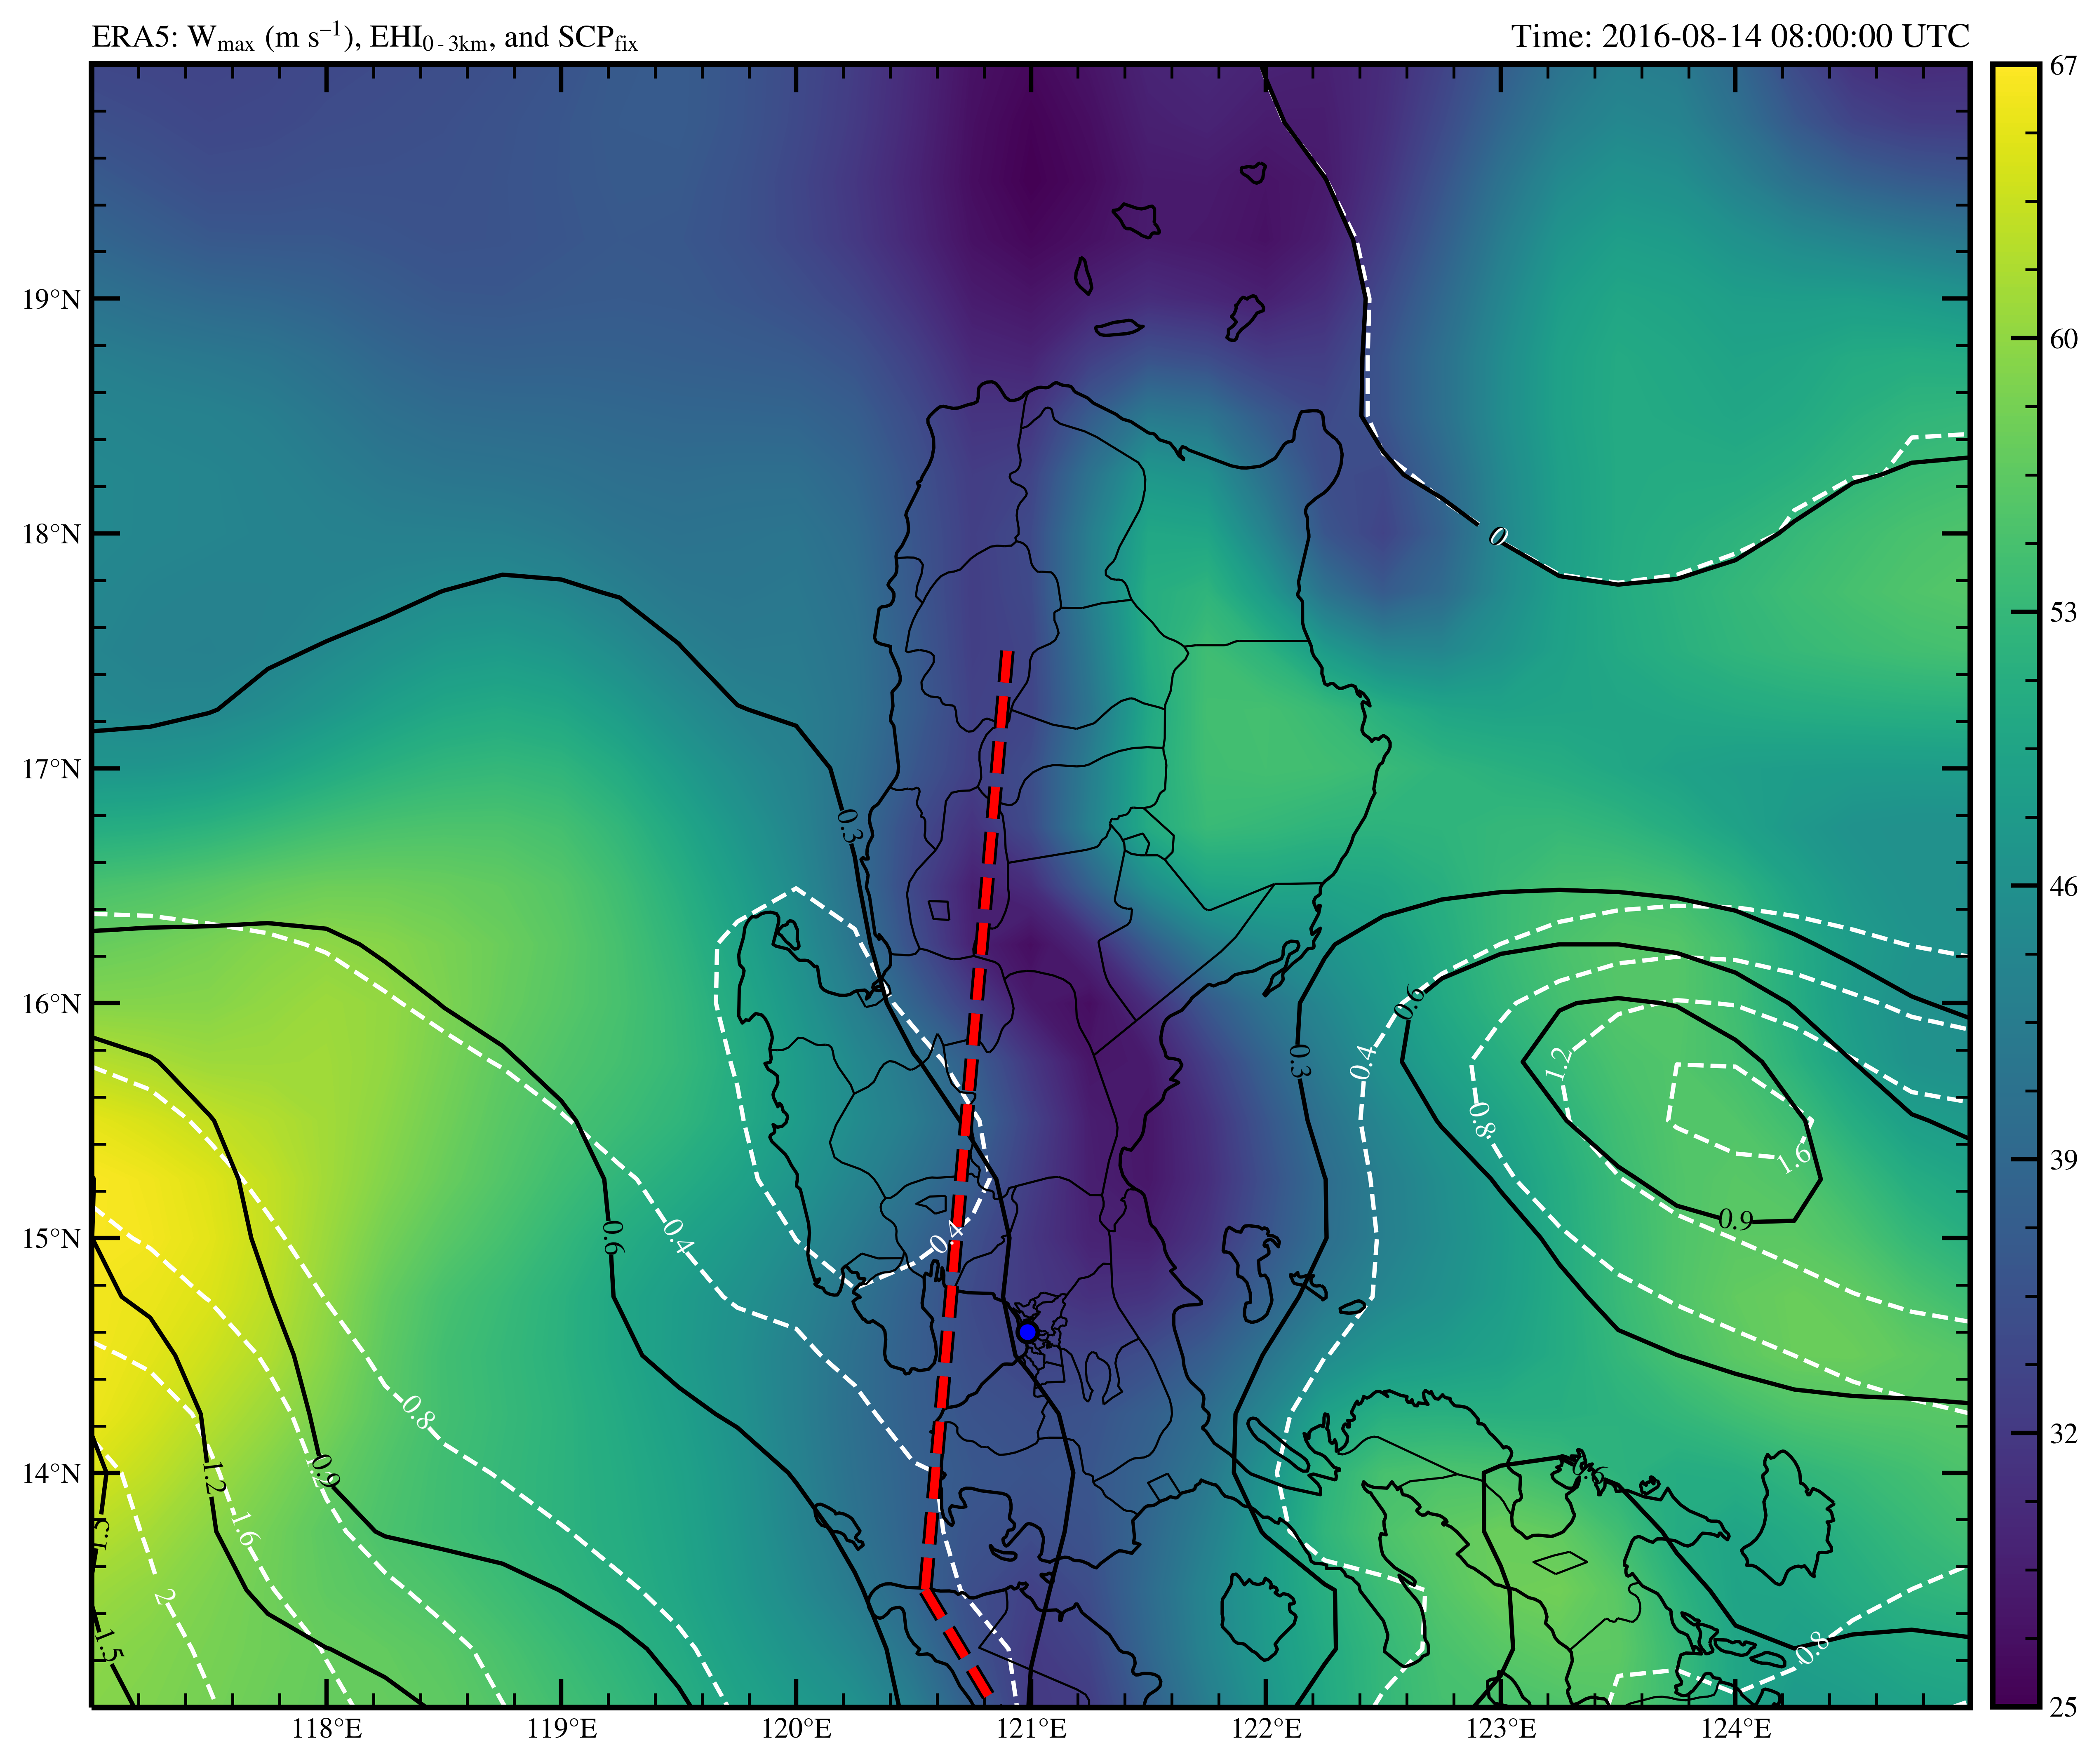

In [109]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Add EHI contours
ehi_range = np.arange(0, 1.8, 0.3)
ehf = ax.contour(lons, lats, ehi, ehi_range, colors='k', transform=datacrs)
ax.clabel(ehf, fmt='%3g')

# Add Updraft Velocity colorfill. Adjust colorbar tickmarks
wmax_range = np.arange(25, 67.1, 0.1)
upwm = ax.contourf(lons, lats, wmax, wmax_range, cmap='viridis', transform=datacrs)
cbar = plt.colorbar(upwm, orientation='vertical', pad=0.01, aspect=35, shrink=0.664,
                    ticks=[25.0, 32.0, 39.0, 46.0, 53.0, 60.0, 67.0])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add SCP contour lines
scp_range = np.arange(0, 2.8, 0.4)
prs = ax.contour(lons, lats, scp, scp_range, colors='white',
                 transform=datacrs, zorder=1, linestyles='--')
ax.clabel(prs, fmt='%3g')

# Create a line(s) that highlights the surface trough
outline=pe.withStroke(linewidth=5, foreground='k')

point1 = dict(lon=120.90, lat=17.50)
point2 = dict(lon=120.55, lat=13.50)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', lw=3, ls='--',
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point3 = dict(lon=120.55, lat=13.50)
point4 = dict(lon=122.40, lat=10.40)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
ax.set_title('ERA5: W$_{max}$ (m s$^{–1}$), EHI$_{0-3 km}$, and SCP$_{fix}$', 
             loc='left', fontsize=11)
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on() 
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('Wmax, EHI, SCP.jpg', bbox_inches="tight")
plt.show()